In [1]:
# Import needed packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, make_scorer

import warnings
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
test_data = pd.read_csv("test.csv")
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [4]:
# class distribution
# transported: False = 0, True = 1
train_data['Transported'].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

the train data is almost balanced

# Pre-Processing

In [5]:
# by default majority class (not transported (False)) will be negative
lb = LabelBinarizer()
train_data['Transported'] = lb.fit_transform(train_data['Transported'].values)
targets = train_data['Transported']

The .isnull() method in Python searches for both None and NaN values

In [6]:
print('\nNull Values in Training \n{}'.format(train_data.isnull().sum()))
print('\nNull Values in Testing \n{}'.format(test_data.isnull().sum()))

print('\nDuplicated values in train {}'.format(train_data.duplicated().sum()))
print('Duplicated values in test {}'.format(test_data.duplicated().sum()))


Null Values in Training 
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Null Values in Testing 
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

Duplicated values in train 0
Duplicated values in test 0


In [7]:
train_data.drop(['PassengerId', 'Transported','Name','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'], axis=1, inplace=True)
test_data.drop(['PassengerId','Name','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'], axis=1, inplace=True)

we have null values everywhere:

    We can use machine learning models to predict missing values based on the other features in the dataset.
    This can be a more sophisticated approach and might require splitting the data into two sets: one with non-null values for training and one with null values for prediction.

In [8]:
for i in train_data.columns:
    print(pd.DataFrame(train_data[i].value_counts(dropna=False)))

            count
HomePlanet       
Earth        4602
Europa       2131
Mars         1759
NaN           201
           count
CryoSleep       
False       5439
True        3037
NaN          217
         count
Cabin         
NaN        199
G/734/S      8
C/137/S      7
B/201/P      7
G/109/P      7
...        ...
G/556/P      1
E/231/S      1
G/545/S      1
G/543/S      1
C/178/S      1

[6561 rows x 1 columns]
               count
Destination         
TRAPPIST-1e     5915
55 Cancri e     1800
PSO J318.5-22    796
NaN              182
      count
Age        
24.0    324
18.0    320
21.0    311
19.0    293
23.0    292
...     ...
72.0      4
78.0      3
79.0      3
76.0      2
77.0      2

[81 rows x 1 columns]
       count
VIP         
False   8291
NaN      203
True     199


In [9]:
train_data["Age"] = train_data["Age"].fillna(train_data["Age"].mean())
test_data["Age"] = test_data["Age"].fillna(test_data["Age"].mean())

In [10]:
train_data["Cabin"] = train_data["Cabin"].fillna('X')
train_data['Cabin'] = train_data['Cabin'].astype(pd.StringDtype())
train_data["Cabin_Category"] = ["Port" if s.rfind('P') > -1 else "Starboard" if s.rfind('S') > -1 else "not_found" for s in train_data["Cabin"]]
print(train_data['Cabin_Category'].value_counts(dropna=False))

Cabin_Category
Starboard    4288
Port         4206
not_found     199
Name: count, dtype: int64


In [11]:
test_data["Cabin"] = test_data["Cabin"].fillna('X')
test_data['Cabin'] = test_data['Cabin'].astype(pd.StringDtype())
test_data["Cabin_Category"] = ["Port" if s.rfind('P') > -1 else "Starboard" if s.rfind('S') > -1 else "not_found" for s in test_data["Cabin"]]
print(test_data['Cabin_Category'].value_counts(dropna=False))

Cabin_Category
Starboard    2093
Port         2084
not_found     100
Name: count, dtype: int64


we can now drop the column "Cabin"

In [12]:
train_data.drop(['Cabin'], axis=1, inplace=True)
test_data.drop(['Cabin'], axis=1, inplace=True)

In [13]:
train_data['Age'] = train_data['Age'].astype(int)
test_data['Age'] = test_data['Age'].astype(int)

In [14]:
# Calculate the mode value of the 'Destination' column
mode_destination = train_data['Destination'].mode().iloc[0]

# Fill missing values in the 'Embarked' column with the mode
train_data['Destination'].fillna(mode_destination, inplace=True)

In [15]:
# Calculate the mode value of the 'Destination' column
mode_destination = test_data['Destination'].mode().iloc[0]

# Fill missing values in the 'Embarked' column with the mode
test_data['Destination'].fillna(mode_destination, inplace=True)

In [16]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   HomePlanet      8492 non-null   object
 1   CryoSleep       8476 non-null   object
 2   Destination     8693 non-null   object
 3   Age             8693 non-null   int32 
 4   VIP             8490 non-null   object
 5   Cabin_Category  8693 non-null   object
dtypes: int32(1), object(5)
memory usage: 373.7+ KB


In [17]:
# Calculate the mode value of the 'HomePlanet' column
mode_home_planet = train_data['HomePlanet'].mode().iloc[0]

# Fill missing values in the 'HomePlanet' column with the mode
train_data['HomePlanet'].fillna(mode_home_planet, inplace=True)



In [18]:
# Calculate the mode value of the 'HomePlanet' column
mode_home_planet_test = test_data['HomePlanet'].mode().iloc[0]

# Fill missing values in the 'HomePlanet' column with the mode
test_data['HomePlanet'].fillna(mode_home_planet_test, inplace=True)

In [19]:
# Calculate the mode value of the 'HomePlanet' column
mode_CryoSleep = train_data['CryoSleep'].mode().iloc[0]

# Fill missing values in the 'HomePlanet' column with the mode
train_data['CryoSleep'].fillna(mode_CryoSleep, inplace=True)


In [20]:
# Calculate the mode value of the 'HomePlanet' column
mode_CryoSleep_test = test_data['CryoSleep'].mode().iloc[0]

# Fill missing values in the 'HomePlanet' column with the mode
test_data['CryoSleep'].fillna(mode_CryoSleep_test, inplace=True)

In [21]:
# Calculate the mode value of the 'HomePlanet' column
mode_VIP = train_data['VIP'].mode().iloc[0]

# Fill missing values in the 'HomePlanet' column with the mode
train_data['VIP'].fillna(mode_VIP, inplace=True)

In [22]:
# Calculate the mode value of the 'HomePlanet' column
mode_VIP_test = test_data['VIP'].mode().iloc[0]

# Fill missing values in the 'HomePlanet' column with the mode
test_data['VIP'].fillna(mode_VIP_test, inplace=True)

In [23]:
print('\nNull Values in Training \n{}'.format(train_data.isnull().sum()))
print('\nNull Values in Testing \n{}'.format(test_data.isnull().sum()))


Null Values in Training 
HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
Cabin_Category    0
dtype: int64

Null Values in Testing 
HomePlanet        0
CryoSleep         0
Destination       0
Age               0
VIP               0
Cabin_Category    0
dtype: int64


In [24]:
test_data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,Cabin_Category
0,Earth,True,TRAPPIST-1e,27,False,Starboard
1,Earth,False,TRAPPIST-1e,19,False,Starboard
2,Europa,True,55 Cancri e,31,False,Starboard
3,Europa,False,TRAPPIST-1e,38,False,Starboard
4,Earth,False,TRAPPIST-1e,20,False,Starboard


In [25]:
train_data = pd.get_dummies(train_data, columns=["HomePlanet","Destination","Cabin_Category"])

In [26]:
test_data = pd.get_dummies(test_data, columns=["HomePlanet","Destination","Cabin_Category"])

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train_data, targets,random_state=42,test_size=0.2,stratify=targets)

train_test_split with stratify=True results in consistent class distribution betwen training and test sets.

In [28]:
print('y_train class distribution')
print(y_train.value_counts(normalize=True))

print('y_test class distribution')
print(y_test.value_counts(normalize=True))

y_train class distribution
Transported
1    0.503595
0    0.496405
Name: proportion, dtype: float64
y_test class distribution
Transported
1    0.503738
0    0.496262
Name: proportion, dtype: float64


Random Forest - Score:  0.6969522714203565


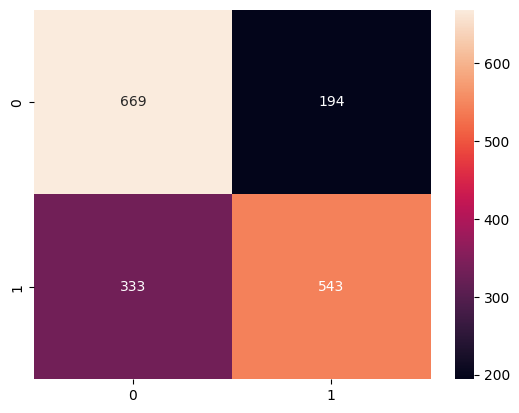

In [29]:
clf = RandomForestClassifier(n_jobs=-1,random_state=42)
clf.fit(X_train, y_train)
pred_1 = clf.predict(X_test)
score_1 = accuracy_score(y_test, pred_1)
print("Random Forest - Score: ", score_1)
cm = confusion_matrix(y_test, pred_1)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [30]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(clf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [31]:
from sklearn.model_selection import RandomizedSearchCV

clf = RandomForestClassifier(n_jobs=-1,random_state=42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 60, stop = 180, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(20, 200, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [6, 7, 8,9,10,11,12,13,14,15]
# Minimum number of samples required at each leaf node
min_samples_leaf = [8,9,10,11,12,13,14,15]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [8, 9, 10, 11, 12, 13, 14, 15],
 'min_samples_split': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 'n_estimators': [60, 73, 86, 100, 113, 126, 140, 153, 166, 180]}


In [32]:
clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
clf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [20, 40, 60, 80, 100, 120,
                                                      140, 160, 180, 200,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [8, 9, 10, 11, 12,
                                                             13, 14, 15],
                                        'min_samples_split': [6, 7, 8, 9, 10,
                                                              11, 12, 13, 14,
                                                              15],
                                        'n_estimators': [60, 73, 86, 100, 113,
                                                         126, 140, 153, 166,
                                                         180]},
                   random_state=42, verbose=2)

In [33]:
clf_random.best_params_

{'n_estimators': 153,
 'min_samples_split': 10,
 'min_samples_leaf': 11,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': True}

In [34]:
clf_random.best_estimator_

RandomForestClassifier(max_depth=40, min_samples_leaf=11, min_samples_split=10,
                       n_estimators=153, n_jobs=-1, random_state=42)

Random Forest - Score:  0.7274295572167913


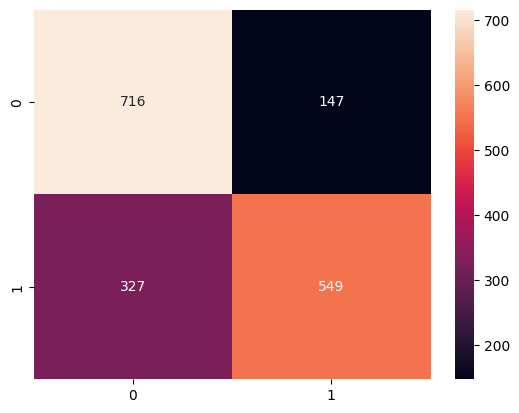

In [35]:

pred_1_random = clf_random.predict(X_test)
score_1_random = accuracy_score(y_test, pred_1_random)
print("Random Forest - Score: ", score_1_random)
cm = confusion_matrix(y_test, pred_1_random)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [36]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10,20,30,40],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [11,12,13],
    'min_samples_split': [2,3,4],
    'n_estimators': [123,133, 143, 153]
}
# Create a based model
clf = RandomForestClassifier(n_jobs=-1,random_state=42)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = clf, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)

In [37]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 12,
 'min_samples_split': 2,
 'n_estimators': 143}

In [38]:
best_grid = grid_search.best_estimator_

Random Forest - Score:  0.7280046003450259


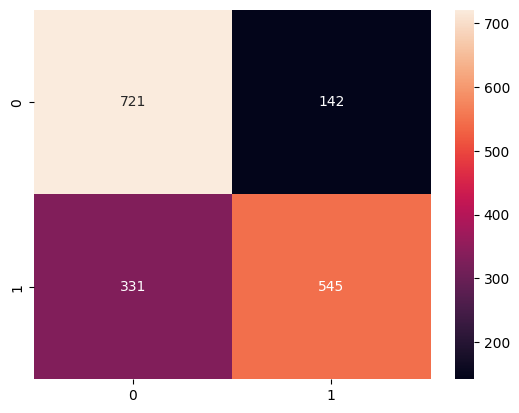

In [39]:
pred_1_grid = best_grid.predict(X_test)
score_1_grid = accuracy_score(y_test, pred_1_grid)
print("Random Forest - Score: ", score_1_grid)
cm = confusion_matrix(y_test, pred_1_grid)
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [40]:
predictions = best_grid.predict(test_data)

In [41]:
predictions = predictions.astype(dtype=bool)

In [42]:
output = pd.DataFrame({'PassengerId': pd.read_csv("test.csv").PassengerId, 'Transported': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
